In [49]:
import patchmatch as pm
import imageio

import numpy as np

In [50]:
def patch_match(source_img, target_img):
    height, width, _ = source_img.shape
    offsets = np.empty((height, width, 2), dtype=np.float32)
    costs = np.empty((height, width), dtype=np.float32)

    PATCHMATCH_SIZE = 8
    MAX_OFFSET = 100
    MIN_OFFSET = 10
    pm.pm(source_img.astype(np.float32),
          target_img.astype(np.float32),
          offsets,
          costs,
          PATCHMATCH_SIZE,
          MIN_OFFSET,
          MAX_OFFSET)

    return offsets[:, :, ::-1]

In [51]:
imgs = []
img = imageio.imread('bike_a.png')
img = (img / 255).astype(np.float64)
imgs.append(img)
img = imageio.imread('bike_b.png')
img = (img / 255).astype(np.float64)
imgs.append(img)
# lib_offsets = patch_match(imgs[0], imgs[1])
# np.save('lib_offset.npy', lib_offsets)
lib_offsets = np.load('lib_offset.npy')

In [52]:
import os

import pyopencl as cl

os.environ['PYOPENCL_NO_CACHE'] = '1'
os.environ['PYOPENCL_NO_CACHE'] = '1'
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

filename = 'patchmatch2.c'
PATCH_SIZE = 5
H_PATCH_SIZE = PATCH_SIZE // 2
MIN_OFFSET = 10
MAX_OFFSET = 100


HEIGHT, WIDTH, _ = img.shape
ctx = cl.create_some_context(False)
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags
program = cl.Program(ctx, open(filename).read()).build()
input_img = np.pad(img, [(H_PATCH_SIZE, H_PATCH_SIZE), (H_PATCH_SIZE, H_PATCH_SIZE), (0, 0)], 'edge')

nnf = np.empty((HEIGHT, WIDTH, 3))
imgs = [input_img.copy()]

In [53]:
inputBuf = [cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=input_img) for _ in range(2)]
outputBuf = cl.Buffer(ctx, mf.WRITE_ONLY | mf.COPY_HOST_PTR, nnf.nbytes, hostbuf=nnf)

# 						 const int min_offset, const int max_offset,
# 						 const int hpatchSize,
# 						 __global double *img1, __global double *img2, __global double *output)
GLOBAL_SIZE = (HEIGHT, WIDTH)
program.randomfill(queue, GLOBAL_SIZE, None,
                                np.int32(HEIGHT),  # height
                                np.int32(WIDTH),  # width
                                np.int32(MIN_OFFSET), 
                                np.int32(MAX_OFFSET), 
                                np.int32(H_PATCH_SIZE),  # width
                                inputBuf[0],
                                inputBuf[1],
                                outputBuf)


init_nnf = np.empty_like(nnf)
cl.enqueue_copy(queue, init_nnf, outputBuf)
nnf = np.copy(init_nnf)

In [54]:
# mf = cl.mem_flags

for i in range(4):
    mf = cl.mem_flags
    inputBuf = [cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=input_img) for _ in range(2)]
    outputBuf = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, nnf.nbytes, hostbuf=nnf)

    ITER = i + 1
    program.propagate(queue, GLOBAL_SIZE, None,
                                   np.int32(H_PATCH_SIZE),  # patchHeight
                                   np.int32(HEIGHT),  # height
                                   np.int32(WIDTH),  # width
                                   np.int32(MIN_OFFSET),
                                   np.int32(MAX_OFFSET),
                                   np.int32(ITER),
                                   inputBuf[0],
                                   inputBuf[1],
                                   outputBuf)


    output_nnf = np.empty_like(nnf)
    cl.enqueue_copy(queue, output_nnf, outputBuf)
    nnf = output_nnf.copy()
    

# __kernel void propagate(const int hpatchSize, const int height, const int width,
# 						const min_offset, const max_offset, const int iteration,
# 						__global double *img1, __global double *img2, __global double *output)

In [55]:
nnf.astype(np.int)

array([[[ 30,  50,   0],
        [ 30,  51,   0],
        [ 30,  52,   0],
        ...,
        [ 11, 213,   0],
        [ 11, 214,   0],
        [ 11, 215,   0]],

       [[ 19,  33,   0],
        [ 19,  34,   0],
        [ 31,  52,   0],
        ...,
        [ 22, 149,   0],
        [ 22, 150,   0],
        [ 12, 215,   0]],

       [[ 20,  14,   0],
        [ 22,  23,   0],
        [ 22,  24,   0],
        ...,
        [ 23, 149,   0],
        [ 23, 150,   0],
        [ 23, 151,   0]],

       ...,

       [[155,  47,   0],
        [155,  48,   0],
        [153,  56,   0],
        ...,
        [161, 221,   0],
        [161, 222,   0],
        [161, 223,   0]],

       [[156,  47,   0],
        [156,  48,   0],
        [156,  49,   0],
        ...,
        [162, 221,   0],
        [162, 222,   0],
        [162, 223,   0]],

       [[157,  47,   0],
        [157,  48,   0],
        [157,  49,   0],
        ...,
        [163, 221,   0],
        [163, 222,   0],
        [163, 223,   0]]

In [56]:
tmp = nnf.copy()
tmp

array([[[3.00000000e+01, 5.00000000e+01, 1.10665129e-01],
        [3.00000000e+01, 5.10000000e+01, 1.16339869e-01],
        [3.00000000e+01, 5.20000000e+01, 1.12633602e-01],
        ...,
        [1.10000000e+01, 2.13000000e+02, 1.40776624e-01],
        [1.10000000e+01, 2.14000000e+02, 1.72179931e-01],
        [1.10000000e+01, 2.15000000e+02, 2.02660515e-01]],

       [[1.90000000e+01, 3.30000000e+01, 7.58169935e-02],
        [1.90000000e+01, 3.40000000e+01, 1.18831219e-01],
        [3.10000000e+01, 5.20000000e+01, 1.22937332e-01],
        ...,
        [2.20000000e+01, 1.49000000e+02, 3.40945790e-02],
        [2.20000000e+01, 1.50000000e+02, 3.71549404e-02],
        [1.20000000e+01, 2.15000000e+02, 2.40784314e-01]],

       [[2.00000000e+01, 1.40000000e+01, 2.02229912e-02],
        [2.20000000e+01, 2.30000000e+01, 4.00307574e-02],
        [2.20000000e+01, 2.40000000e+01, 6.34525183e-02],
        ...,
        [2.30000000e+01, 1.49000000e+02, 2.58054594e-02],
        [2.30000000e+01, 1.50

In [57]:
nnf.astype(np.int)

array([[[ 30,  50,   0],
        [ 30,  51,   0],
        [ 30,  52,   0],
        ...,
        [ 11, 213,   0],
        [ 11, 214,   0],
        [ 11, 215,   0]],

       [[ 19,  33,   0],
        [ 19,  34,   0],
        [ 31,  52,   0],
        ...,
        [ 22, 149,   0],
        [ 22, 150,   0],
        [ 12, 215,   0]],

       [[ 20,  14,   0],
        [ 22,  23,   0],
        [ 22,  24,   0],
        ...,
        [ 23, 149,   0],
        [ 23, 150,   0],
        [ 23, 151,   0]],

       ...,

       [[155,  47,   0],
        [155,  48,   0],
        [153,  56,   0],
        ...,
        [161, 221,   0],
        [161, 222,   0],
        [161, 223,   0]],

       [[156,  47,   0],
        [156,  48,   0],
        [156,  49,   0],
        ...,
        [162, 221,   0],
        [162, 222,   0],
        [162, 223,   0]],

       [[157,  47,   0],
        [157,  48,   0],
        [157,  49,   0],
        ...,
        [163, 221,   0],
        [163, 222,   0],
        [163, 223,   0]]

In [58]:
grids = np.meshgrid(np.arange(NNF_WIDTH), np.arange(NNF_HEIGHT), indexing="xy")
cord = np.concatenate((grids[1][..., np.newaxis], grids[0][..., np.newaxis]), axis=2)

NameError: name 'NNF_WIDTH' is not defined

In [59]:
a = nnf[:, :, :2] - cord

In [60]:
a

array([[[ 30.,  50.],
        [ 30.,  50.],
        [ 30.,  50.],
        ...,
        [ 11., -23.],
        [ 11., -23.],
        [ 11., -23.]],

       [[ 18.,  33.],
        [ 18.,  33.],
        [ 30.,  50.],
        ...,
        [ 21., -87.],
        [ 21., -87.],
        [ 11., -23.]],

       [[ 18.,  14.],
        [ 20.,  22.],
        [ 20.,  22.],
        ...,
        [ 21., -87.],
        [ 21., -87.],
        [ 21., -87.]],

       ...,

       [[-17.,  47.],
        [-17.,  47.],
        [-19.,  54.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]],

       [[-17.,  47.],
        [-17.,  47.],
        [-17.,  47.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]],

       [[-17.,  47.],
        [-17.,  47.],
        [-17.,  47.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]]])

In [23]:
lib_offsets.astype(np.int)[:HEIGHT, :WIDTH]

array([[[  8,   6],
        [ 12,   7],
        [ 12,   7],
        ...,
        [ 22, -27],
        [ 22, -27],
        [ 22, -27]],

       [[  8,   6],
        [ 12,   7],
        [ 12,   7],
        ...,
        [ 22, -27],
        [ 22, -27],
        [ 22, -27]],

       [[  8,   6],
        [  8,   6],
        [ 12,   7],
        ...,
        [ 22, -27],
        [ 22, -27],
        [ 22, -27]],

       ...,

       [[-21,   0],
        [-27,  -1],
        [-27,  -1],
        ...,
        [-10,   0],
        [-10,   0],
        [-10,   0]],

       [[-21,   0],
        [-27,  -1],
        [ -2,  10],
        ...,
        [-10,   0],
        [-10,   0],
        [-10,   0]],

       [[-21,   0],
        [-21,   0],
        [ -2,  10],
        ...,
        [-10,   0],
        [-10,   0],
        [-10,   0]]])

In [27]:
a.shape

(175, 239, 2)

In [28]:
output_nnf.astype(np.int)

array([[[ 33,  18,   0],
        [ 33,  19,   0],
        [ 33,  20,   0],
        ...,
        [ 11, 213,   0],
        [ 11, 214,   0],
        [ 11, 215,   0]],

       [[ 19,  33,   0],
        [ 19,  34,   0],
        [ 21,  25,   0],
        ...,
        [ 78, 190,   1],
        [ 78, 191,   1],
        [ 78, 192,   1]],

       [[ 35,  20,   1],
        [ 22,  23,   0],
        [ 22,  24,   0],
        ...,
        [ 15, 220,   0],
        [ 15, 221,   0],
        [ 15, 222,   0]],

       ...,

       [[146,  26,   0],
        [146,  27,   0],
        [159,  59,   0],
        ...,
        [161, 221,   0],
        [161, 222,   0],
        [161, 223,   0]],

       [[147,  26,   0],
        [147,  27,   0],
        [160,  59,   0],
        ...,
        [162, 221,   0],
        [162, 222,   0],
        [162, 223,   0]],

       [[148,  26,   0],
        [154,  40,   0],
        [157,  49,   0],
        ...,
        [163, 221,   0],
        [163, 222,   0],
        [163, 223,   0]]

In [29]:
np.min(lib_offsets)

-100.0

In [30]:
nnf

array([[[3.30000000e+01, 1.80000000e+01, 2.04136870e-01],
        [3.30000000e+01, 1.90000000e+01, 1.90495963e-01],
        [3.30000000e+01, 2.00000000e+01, 1.93156478e-01],
        ...,
        [1.10000000e+01, 2.13000000e+02, 1.40776624e-01],
        [1.10000000e+01, 2.14000000e+02, 1.72179931e-01],
        [1.10000000e+01, 2.15000000e+02, 2.02660515e-01]],

       [[1.90000000e+01, 3.30000000e+01, 7.58169935e-02],
        [1.90000000e+01, 3.40000000e+01, 1.18831219e-01],
        [2.10000000e+01, 2.50000000e+01, 1.80899654e-01],
        ...,
        [7.80000000e+01, 1.90000000e+02, 1.12376778e+00],
        [7.80000000e+01, 1.91000000e+02, 1.10231449e+00],
        [7.80000000e+01, 1.92000000e+02, 1.08301423e+00]],

       [[3.50000000e+01, 2.00000000e+01, 1.44622837e+00],
        [2.20000000e+01, 2.30000000e+01, 4.00307574e-02],
        [2.20000000e+01, 2.40000000e+01, 6.34525183e-02],
        ...,
        [1.50000000e+01, 2.20000000e+02, 2.40845829e-01],
        [1.50000000e+01, 2.21

In [31]:
nnf[100, 200]

array([ 85.       , 187.       ,   0.3654133])

In [32]:
lib_offsets[100, 210]

array([15., -9.], dtype=float32)

In [36]:
input_img[100, 200]

array([0.19215686, 0.22745098, 0.36470588])

In [37]:
input_img[85, 187]

array([0.46666667, 0.45490196, 0.41176471])

In [38]:
input_img[115, 201]

array([0.40784314, 0.3254902 , 0.29803922])

In [39]:
a

array([[[ 33.,  18.],
        [ 33.,  18.],
        [ 33.,  18.],
        ...,
        [ 11., -23.],
        [ 11., -23.],
        [ 11., -23.]],

       [[ 18.,  33.],
        [ 18.,  33.],
        [ 20.,  23.],
        ...,
        [ 77., -46.],
        [ 77., -46.],
        [ 77., -46.]],

       [[ 33.,  20.],
        [ 20.,  22.],
        [ 20.,  22.],
        ...,
        [ 13., -16.],
        [ 13., -16.],
        [ 13., -16.]],

       ...,

       [[-26.,  26.],
        [-26.,  26.],
        [-13.,  57.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]],

       [[-26.,  26.],
        [-26.,  26.],
        [-13.,  57.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]],

       [[-26.,  26.],
        [-20.,  39.],
        [-17.,  47.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]]])

In [42]:
np.mean(a - lib_offsets)

-0.14473401075911535

ValueError: x must have 2 or fewer dimensions

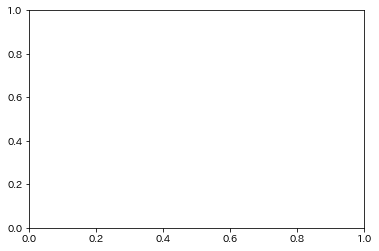

In [46]:
import matplotlib.pyplot as plt

array([[[ 30.,  50.],
        [ 30.,  50.],
        [ 30.,  50.],
        ...,
        [ 11., -23.],
        [ 11., -23.],
        [ 11., -23.]],

       [[ 18.,  33.],
        [ 18.,  33.],
        [ 30.,  50.],
        ...,
        [ 21., -87.],
        [ 21., -87.],
        [ 11., -23.]],

       [[ 18.,  14.],
        [ 20.,  22.],
        [ 20.,  22.],
        ...,
        [ 21., -87.],
        [ 21., -87.],
        [ 21., -87.]],

       ...,

       [[-17.,  47.],
        [-17.,  47.],
        [-19.,  54.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]],

       [[-17.,  47.],
        [-17.,  47.],
        [-17.,  47.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]],

       [[-17.,  47.],
        [-17.,  47.],
        [-17.,  47.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]]])

(array([ 1203.,  1371.,  1300.,  4858., 10753., 10738.,  6241.,  1913.,
         1870.,  1578.]),
 array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.,  100.]),
 <a list of 10 Patch objects>)

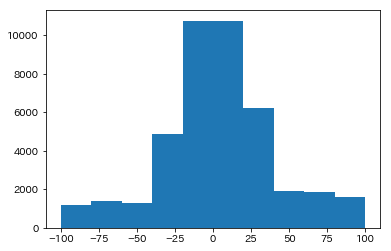

In [67]:
plt.hist(a[:, :, 0].flatten())

(array([  197.,   419.,   555.,  1037.,  9253., 26940.,  2054.,   683.,
          474.,   213.]),
 array([-100. ,  -80.1,  -60.2,  -40.3,  -20.4,   -0.5,   19.4,   39.3,
          59.2,   79.1,   99. ], dtype=float32),
 <a list of 10 Patch objects>)

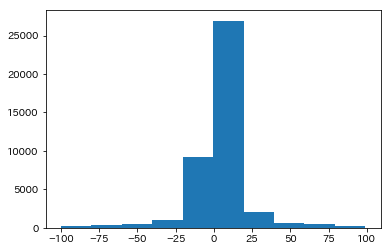

In [69]:
plt.hist(lib_offsets[:, :, 0].flatten())

In [72]:
np.min(np.abs(lib_offsets))

0.0

In [73]:
a

array([[[ 30.,  50.],
        [ 30.,  50.],
        [ 30.,  50.],
        ...,
        [ 11., -23.],
        [ 11., -23.],
        [ 11., -23.]],

       [[ 18.,  33.],
        [ 18.,  33.],
        [ 30.,  50.],
        ...,
        [ 21., -87.],
        [ 21., -87.],
        [ 11., -23.]],

       [[ 18.,  14.],
        [ 20.,  22.],
        [ 20.,  22.],
        ...,
        [ 21., -87.],
        [ 21., -87.],
        [ 21., -87.]],

       ...,

       [[-17.,  47.],
        [-17.,  47.],
        [-19.,  54.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]],

       [[-17.,  47.],
        [-17.,  47.],
        [-17.,  47.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]],

       [[-17.,  47.],
        [-17.,  47.],
        [-17.,  47.],
        ...,
        [-11., -15.],
        [-11., -15.],
        [-11., -15.]]])

In [74]:
a[100, 100]

array([-29., -31.])

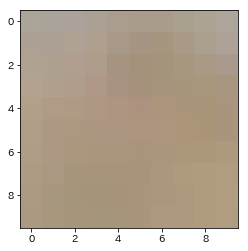

In [75]:
plt.imshow(input_img[95:105, 95:105])

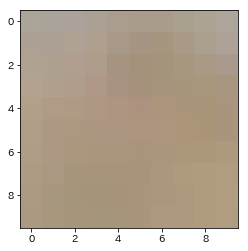

In [75]:
plt.imshow(input_img[80:, 95:105])